In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import tqdm

import torch
import torch.nn as nn

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import pairwise_distances, pairwise_distances_argmin_min

from functools import reduce
import operator
from multiprocess import Pool
from ripser import Rips
import random

from IPython.display import clear_output

import plotly 
plotly.tools.set_credentials_file(username='akorotin', api_key='Lhl71tOCZiqbDY3viMnQ')
import plotly.plotly as py
import plotly.graph_objs as go

from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
from scipy.interpolate import griddata

from scipy.spatial import distance_matrix

import pandas as pd

In [2]:
import sublevel as sb

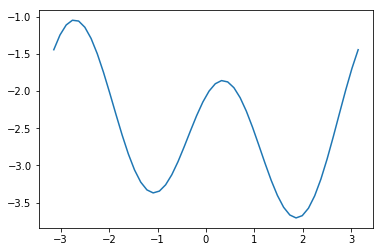

In [3]:
COEFS_NUM = 2
np.random.seed(6)
sin_coefs = np.random.normal(size=COEFS_NUM)
cos_coefs = np.random.normal(size=COEFS_NUM)
const = np.random.normal()

def f(x):
    ns = np.linspace(1, COEFS_NUM, COEFS_NUM).reshape(-1, 1)
    return const + np.sin((ns * x).T).dot(sin_coefs) + np.cos((ns * x).T).dot(sin_coefs)

X = np.linspace(-np.pi, np.pi, num=50)
plt.plot(X, f(X))

y = torch.tensor(f(X), dtype=torch.float32).reshape(-1, 1)
X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)

In [4]:
def set_weights(net, theta):
    pos = 0
    for p in net.parameters():
        dim = reduce(operator.mul, p.size(), 1)
        p.data = torch.tensor(
            theta[
                pos:pos+dim
            ], dtype=torch.float32
        ).reshape(p.size())
        pos += dim
    return net

def mse_loss(net, theta, X, y):
    net = set_weights(net, theta)
    return mse(net(X).clone().detach().numpy().flatten(), y.clone().detach().numpy().flatten())

def get_losses(net, thetas, X, y):
    with Pool() as pool:
        losses = pool.map(lambda theta: mse_loss(net, theta, X, y), thetas)
    return np.array(losses)

def draw_theta(net, theta, X, y):
    X = np.linspace(-np.pi, np.pi, num=50)
    y = torch.tensor(f(X), dtype=torch.float32).reshape(-1, 1)
    X = torch.tensor(X, dtype=torch.float32).reshape(-1, 1)
    net = set_weights(net, theta)
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    ax.plot(X.clone().detach().numpy().flatten(), y.detach().numpy().flatten(), c='g')
    ax.plot(X.clone().detach().numpy().flatten(), net(X).detach().numpy().flatten(), c='b')

def find_theta(net, X, y, init_theta):
    net = set_weights(net, init_theta)
    opt = torch.optim.Adam(net.parameters(), lr=1e-4)

    for _ in range(100000):
        loss = ((net(X) - y.reshape(-1, 1)) ** 2).mean()
        loss.backward()
        opt.step()
        opt.zero_grad()

    theta = np.hstack(p.detach().numpy().flatten() for p in net.parameters())
    return theta

def find_thetas(net, X, y, init_thetas):
    with Pool(8) as pool:
        thetas = list(pool.map(
            lambda init_theta: find_theta(deepcopy(net), X, y, init_theta),
            init_thetas
        ))
    return thetas

## Networks

In [44]:
net2 = nn.Sequential(nn.Linear(1, 2), nn.ReLU(), nn.Linear(2, 1))
net3 = nn.Sequential(nn.Linear(1, 3), nn.ReLU(), nn.Linear(3, 1))
net4 = nn.Sequential(nn.Linear(1, 4), nn.ReLU(), nn.Linear(4, 1))
net22 = nn.Sequential(nn.Linear(1, 2), nn.ReLU(), nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))
net32 = nn.Sequential(nn.Linear(1, 3), nn.ReLU(), nn.Linear(3, 2), nn.ReLU(), nn.Linear(2, 1))

## Two chosen minimums for net2

In [6]:
best2 = np.array([[ 0.8003785 ,  0.79920864,  1.9280311 ,  1.2550498 , -2.5756967 ,
         2.6581223 , -1.1769434 ], [ 0.4067271 ,  1.4423316 ,  2.077474  , -3.2719536 , -0.8506611 ,
         1.8385969 , -0.88007826]], dtype = np.float32)
get_losses(net2, best2, X, y)

array([0.30695632, 0.32351503], dtype=float32)

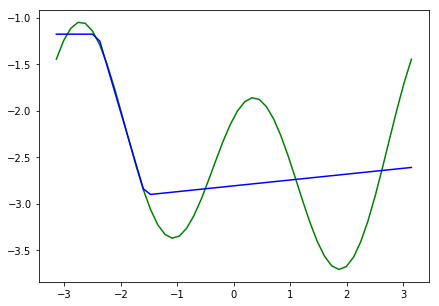

In [7]:
draw_theta(net2, best2[0], X, y)

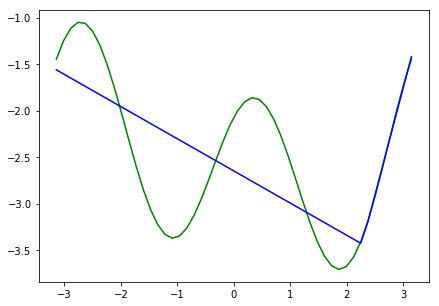

In [8]:
draw_theta(net2, best2[1], X, y)

## Renorming

In [9]:
def RenormTheta(theta, value, coords):
    for turp in coords:
        if (theta[turp[1]] < 0):
            value *= -1
        theta[turp[0]] /= theta[turp[1]]/value
        theta[turp[2]] *= theta[turp[1]]/value
        theta[turp[1]] = value

In [10]:
RenormTheta(best2[0], 1.5, [(2,0,4), (3,1,5)])
RenormTheta(best2[1], 1.5, [(2,0,4), (3,1,5)])
best2

array([[ 1.5       ,  1.5       ,  3.6133487 ,  2.3555486 , -1.3743548 ,
         1.4162629 , -1.1769434 ],
       [ 1.5       ,  1.5       ,  7.6616755 , -3.4027755 , -0.23065795,
         1.767911  , -0.88007826]], dtype=float32)

## Grid search 

In [11]:
def ndim_grid(start,stop, steps):
    # Set number of dimensions
    ndims = len(start)
    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i], steps[i], dtype = np.float32) for i in range(ndims)]
    # Finally use meshgrid to form all combinations corresponding to all
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

def get_min_max(best, sh):
    pass

In [14]:
shape = np.array([1, 1, 30, 36, 20, 10, 10], dtype = np.int32)
min = np.array([1.5, 1.5, 2.2, -4,  -2.0, 1.1, -1.5], dtype = np.float32)
max = np.array([1.5, 1.5, 8.0, 3.0, -0.2, 2.0, -0.6], dtype = np.float32)

In [15]:
grid1 = ndim_grid(min, max, shape)

In [16]:
loss = get_losses(net2, grid1, X, y)

In [17]:
np.savetxt('net2.txt', loss)

In [18]:
shape_red = np.array([30, 36, 20, 10, 10], dtype = np.int32)
ans = sb.grid_shape(loss, shape_red)

In [19]:
Res = pd.DataFrame.from_dict(ans)

In [20]:
Res.loc[Res['Number of point in dead cluster'] > 100]

,birth value,death value,birth of swallowed cluster,Id of dead minimum,Id of saddle,Id of swallowed minimum,Number of point in dead cluster,Number of point in swallowed cluster
509,0.311138,0.365109,0.309139,566734,568823,638914,188,225
511,0.309267,0.364245,0.309139,566823,568912,638914,108,114
523,0.313676,0.365604,0.312065,568464,496452,568553,226,77
526,0.312065,0.368086,0.309139,568553,496642,638914,353,565
644,0.309139,inf,inf,638914,-1,-1,2160000,-1
646,0.310403,0.367645,0.309139,639003,568901,638914,105,446
729,0.430413,0.445315,0.328696,659773,515861,1447951,188,9139
941,0.342372,0.394553,0.328696,801861,871980,1447951,2141,2502
1127,0.328696,0.779223,0.309139,1447951,541402,638914,51153,26311


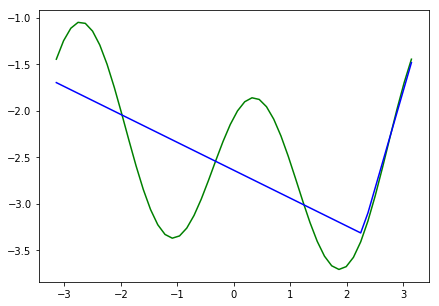

In [23]:
draw_theta(net2, grid1[1447951], X, y)

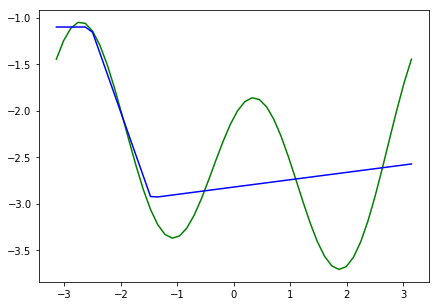

In [25]:
draw_theta(net2, grid1[638914], X, y)

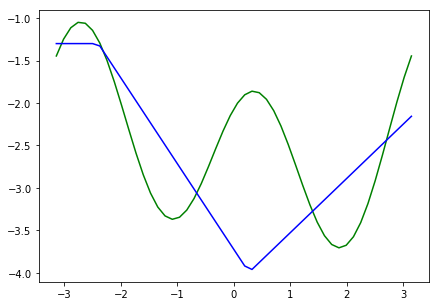

In [26]:
draw_theta(net2, grid1[541402], X, y)

In [27]:
grid1[541402]

array([ 1.5       ,  1.5       ,  3.6000001 , -0.4       , -0.67368424,
        1.1       , -1.3       ], dtype=float32)

In [28]:
loss.shape

(2160000,)

## Random for 2 network:

## Move to 3 network:

In [90]:
init_thetas = np.array([[1.5, 1.5, 1.5, 3.6133487, 2.3555486, best2[0][2]/2 + best2[0][3]/2, 
                         -1.3743548, 1.4162629, 0., -1.1769434],
                        [1.5, 1.5, 1.5, 7.6616755, -3.4027755, best2[1][2]/2 + best2[1][3]/2,
                         -0.23065795, 1.767911, 0., -0.88007826]], dtype=np.float32)

In [91]:
best3 = find_thetas(net3, X, y, init_thetas)
clear_output()

In [92]:
get_losses(net3, best3, X, y)

array([0.3068874 , 0.24122545], dtype=float32)

In [96]:
RenormTheta(best3[0], 1.5, [(3,0,6), (4,1,7), (5,2,8)])
RenormTheta(best3[1], 1.5, [(3,0,6), (4,1,7), (5,2,8)])
best3

[array([ 1.5       ,  1.5       ,  1.5       ,  3.6674376 ,  2.3697934 ,
         3.3033736 , -1.0720743 ,  1.4761126 , -0.36213884, -1.1769456 ],
       dtype=float32),
 array([ 1.5       ,  1.5       ,  1.5       ,  5.2871966 , -3.618509  ,
         2.2120872 , -0.72524196,  1.6274271 ,  0.6434754 , -0.39982003],
       dtype=float32)]

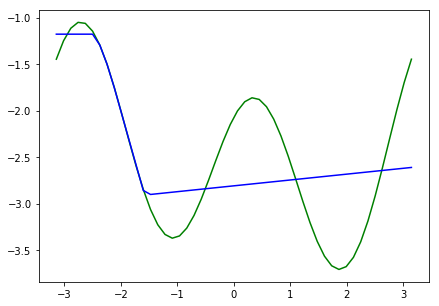

In [97]:
draw_theta(net3, best3[0], X, y)

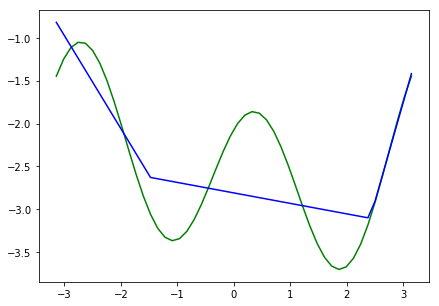

In [133]:
draw_theta(net3, best3[1], X, y)

In [139]:
shape3 = np.array([1,   1,   1,  16,  15,  11,   10,  10,   10,    6], dtype = np.int32)
min3 = np.array([1.5, 1.5, 1.5, 2.0,  -4, 2.0, -2.0, 1.1, -1.1, -1.5], dtype = np.float32)
max3 = np.array([1.5, 1.5, 1.5, 8.0, 3.0, 4.0, -0.2, 2.0,  0.9, -0.6], dtype = np.float32)

In [140]:
grid3 = ndim_grid(min3, max3, shape3)

In [141]:
loss3 = get_losses(net3, grid3, X, y)

In [142]:
np.savetxt('net3.txt', loss3)

In [143]:
shape_red3 = np.array([16,  15,  11,   10,  10,   10,    6], dtype = np.int32)
ans3 = sb.grid_shape(loss3, shape_red3)
Res3 = pd.DataFrame.from_dict(ans3)

In [145]:
Res3.loc[((Res3['Number of point in dead cluster'] > 10000))]

,birth value,death value,birth of swallowed cluster,Id of dead minimum,Id of saddle,Id of swallowed minimum,Number of point in dead cluster,Number of point in swallowed cluster
3741,0.308592,0.480215,0.308173,3885968,4826893,4856894,25395,331
4998,0.308173,0.803093,0.228843,4856894,593419,5037296,202690,184339
5419,0.228843,inf,inf,5037296,-1,-1,15840000,-1
6798,0.247111,0.503787,0.228843,6016604,4960728,5037296,10342,17339
9241,0.273613,0.530245,0.228843,9971200,3106956,5037296,15805,32175
9745,0.328282,0.583871,0.228843,13931792,4097490,5037296,21841,62631


In [ ]:
grid1